# Asymmetric Potentials
For convenience the key equations are given below from https://arxiv.org/pdf/astro-ph/9407016.pdf:

1) Fokker-Planck equation
$$    \frac{\partial P(\varphi,t)}{\partial t} = \frac{1}{3H}\frac{\partial}{\partial \varphi}\left(V'(\varphi) P(\varphi,t)\right) + \frac{H^3}{8\pi^2}\frac{\partial^2 P(\varphi,t)}{\partial \varphi^2} $$

2) Schrodinger-like equation
$$     -\frac{1}{2}\frac{\partial^2 \Phi_n(\varphi)}{\partial \varphi^2} + W(\varphi) \Phi_n (\varphi) = \frac{4\pi^2\Lambda_n}{H^3}\Phi_n(\varphi) $$

3) Effective potential
$$ W(\varphi) = \frac{1}{2}\left[v'(\varphi)^2-v''(\varphi)\right], \> \> v(\varphi) = \frac{4\pi^2}{3H^4} V(\varphi) $$

4) Solutions take the form
$$ P(\varphi,t) = \exp\left(-\frac{4\pi^2 V(\varphi)}{3H^4}\right) \sum^{\infty}_{n=0} a_n \Phi_n (\varphi) e^{-\Lambda_n (t-t_0)} $$

In [1]:
import numpy as np
from math import factorial
from scipy import optimize
from scipy.integrate import odeint, simps
from scipy.special import eval_hermite
import matplotlib.pyplot as plt
%matplotlib inline

Here we know consider a potential of the form
$$V(\varphi) = \mu^3 \varphi + \frac{1}{2}m^2\varphi^2 + \frac{1}{4}\lambda \varphi^4. $$
Following https://arxiv.org/pdf/2001.04494.pdf, the Schrodinger-like equation can be expressed in terms of dimensionless quantities:
$$ \bar{\alpha} \equiv \frac{-m^2}{\sqrt{\lambda}H^2}, \> \> \beta = \frac{\mu^3}{\lambda^{1/4}H^3}.  $$
We also have
$$ z \equiv \frac{\lambda^{1/4}\Omega}{H}\varphi, \>\> \Omega \equiv 1 + \sqrt{\bar{\alpha}}+\beta. $$
With the above parameters the Schrödinger-like equation takes the form 
$$\frac{\partial \Phi_n(z)}{\partial z} \equiv Y, $$
$$\frac{\partial Y}{\partial z} = \left(4\pi^2\frac{\bar{\alpha}+\frac{4\pi^2}{3}\beta^2}{3\Omega^2}-\frac{32\pi^4\bar{\alpha}\beta z}{9\Omega^3}-4\pi^2\frac{1-\frac{4\pi^2}{9}\bar{\alpha}^2}{\Omega^4}z^2+\frac{32\pi^4\beta z^3}{9\Omega^5}-\frac{32\pi^4\bar{\alpha} z^4}{9\Omega^6} + \frac{16\pi^4 z^6}{9\Omega^8}-\frac{8\pi^2(1+\bar{\alpha}+\beta^2)\tilde{\Lambda}_n}{\Omega^2}\right)\Phi_n(z).  $$
Eigenvalues are rescaled as 
$$\tilde{\Lambda}_n(\alpha) = \frac{\Lambda_n}{\lambda^{1/2}H(1+\bar{\alpha}+\beta^2)}. $$
For now let us set $\bar{\alpha}=1$, $\beta=0.5$

In [315]:
# Setting parameters
alpha_bar = 1
beta = 0.5
omega = 1 + np.sqrt(alpha_bar) + beta

## WKB approximation
$$ Q(z) = 4\pi^2\frac{\bar{\alpha}+\frac{4\pi^2}{3}\beta^2}{3\Omega^2}-\frac{32\pi^4\bar{\alpha}\beta z}{9\Omega^3}-4\pi^2\frac{1-\frac{4\pi^2}{9}\bar{\alpha}^2}{\Omega^4}z^2+\frac{32\pi^4\beta z^3}{9\Omega^5}-\frac{32\pi^4\bar{\alpha} z^4}{9\Omega^6} + \frac{16\pi^4 z^6}{9\Omega^8}-\frac{8\pi^2(1+\bar{\alpha}+\beta^2)\tilde{\Lambda}_n}{\Omega^2}, $$
$$ Q'(z) = -\frac{32\pi^4\bar{\alpha}\beta}{9\Omega^3}-8\pi^2\frac{1-\frac{4\pi^2}{9}\bar{\alpha}^2}{\Omega^4}z+\frac{32\pi^4\beta z^2}{3\Omega^5}-\frac{128\pi^4\bar{\alpha} z^3}{9\Omega^6} + \frac{32\pi^4 z^5}{3\Omega^8}, $$
$$ Q''(z) = -8\pi^2\frac{1-\frac{4\pi^2}{9}\bar{\alpha}^2}{\Omega^4}+\frac{64\pi^4\beta z}{3\Omega^5}-\frac{128\pi^4\bar{\alpha} z^2}{3\Omega^6} + \frac{160\pi^4 z^4}{3\Omega^8}. $$


$$S_0(z) = \pm \int^z_{z_0}\sqrt{Q(x)} dx, $$
$$S_1(z) = -\frac{1}{4}\left[\text{ln}Q(x)\right]^z_{z_0}, $$
$$S_2(z) = -\frac{1}{4}\frac{Q'(z)}{Q(z)^2} - \frac{1}{8}\int^z_{z_0} \frac{Q''(x)}{Q(x)^3}dx.$$
The solution then takes the form 
$$S(z) = \frac{c_1}{Q(z)^{1/4}}\text{exp}\left[\int^z_{z_0} \sqrt{Q(x)}dx -\frac{1}{4}\frac{Q'(z)}{Q(z)^2} - \frac{1}{8}\int^z_{z_0} \frac{Q''(x)}{Q(x)^3}dx\right] + \frac{c_2}{Q(z)^{1/4}}\text{exp}\left[-\int^z_{z_0} \sqrt{Q(x)}dx +\frac{1}{4}\frac{Q'(z)}{Q(z)^2} + \frac{1}{8}\int^z_{z_0} \frac{Q''(x)}{Q(x)^3}dx\right] $$

In [316]:
# Eigenvalue
eigenvalue = 0

def Q_function(z):
    '''Evaluates Q(z) defined above
    z: array of values for which Q(z) is to be evaluated'''
    
    # Break up calculation into multiple parts
    x_1 = ((alpha_bar + ((4*np.pi**2)/3)*beta**2)/(3*omega**2))*4*np.pi**2 
    x_2 = - ((32*np.pi**4)*alpha_bar*beta*z)/(9*omega**3)
    x_3 = - (4*np.pi**2)*((1 - (4*(np.pi*alpha_bar)**2)/9)/(omega**4))*z**2
    x_4 = ((32*np.pi**4)*beta*z**3)/(9*omega**5) - ((32*np.pi**4)*alpha_bar*z**4)/(9*omega**6)
    x_5 = ((16*np.pi**4)*z**6)/(9*omega**8) - ((1 + alpha_bar + beta**2)*eigenvalue*8*np.pi**2)/(omega**2)
    
    # Computes full function
    Q = x_1 + x_2 + x_3 + x_4 + x_5
    
    return Q

In [317]:
def Q_function_gradient(z):
    '''Evaluates the gradient for Q(z) defined above
    z: array of values for which Q(z) is to be evaluated'''
    
    # Break up calculation into multiple parts
    x_1 = - ((32*np.pi**4)*alpha_bar*beta)/(9*omega**3)
    x_2 = - (8*np.pi**2)*((1 - (4*(np.pi*alpha_bar)**2)/9)/(omega**4))*z
    x_3 = ((32*np.pi**4)*beta*z**2)/(3*omega**5) - ((128*np.pi**4)*alpha_bar*z**3)/(9*omega**6)
    x_4 = ((32*np.pi**4)*z**5)/(3*omega**8) 
    
    # Computes full function
    Q_gradient = x_1 + x_2 + x_3 + x_4
    
    return Q_gradient

def Q_second_derivative(z):
    '''Evaluates the second derivative for Q(z) defined above
    z: array of values for which Q(z) is to be evaluated'''
    
    # Break up calculation into multiple parts
    x_1 = - (8*np.pi**2)*((1 - (4*(np.pi*alpha_bar)**2)/9)/(omega**4))
    x_2 = ((64*np.pi**4)*beta*z)/(3*omega**5) - ((128*np.pi**4)*alpha_bar*z**2)/(3*omega**6)
    x_3 = ((160*np.pi**4)*z**4)/(3*omega**8) 
    
    # Computes full function
    Q_second_derivative = x_1 + x_2 + x_3
    
    return Q_second_derivative

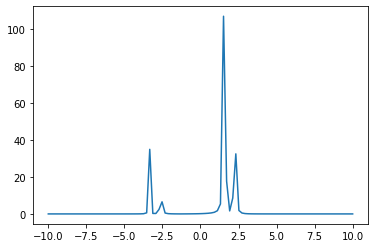

In [331]:
# Plotting ratio of gradient of Q with Q^2
z = np.linspace(-10, 10, 100)
Q = Q_function(z)
Q_gradient = Q_function_gradient(z)
plt.plot(z, abs(Q_gradient/(Q**2)))

(0, 1)

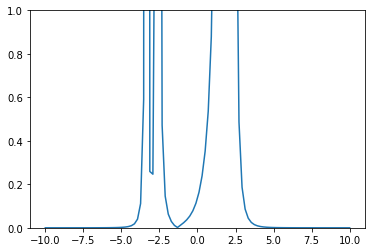

In [332]:
# Plotting ratio of gradient of Q with Q^2
z = np.linspace(-10, 10, 100)
Q = Q_function(z)
Q_gradient = Q_function_gradient(z)
plt.plot(z, abs(Q_gradient/(Q**2)))
plt.ylim(0, 1)

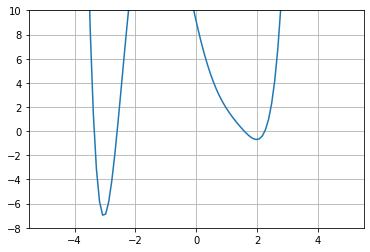

In [333]:
# Plot Q(z), points where Q(z) = 0 are analogous to classical turning points in quantum mechanics
z = np.linspace(-5, 5, 100)
Q = Q_function(z)
plt.plot(z, Q)
plt.ylim(-8, 10)
plt.grid()

In [339]:
def WKB_function(eigenvalue, c_1, c_2, lower_limit, upper_limit):
    '''Evaluates WKB approximation of eigenfunction to second-order
    eigenvalue: guess eigenvalue
    c_1: guess amplitude (right-moving)
    c_2: guess amplitude (left-moving)
    upper_limit: upper integration limit
    lower_limit: lower integration limit'''
    
    # Creates array of z values
    z = np.linspace(lower_limit, upper_limit, 1000, dtype=complex)
    dz = z[1] - z[0]
    
    # Q and its derivatives
    Q = Q_function(z)
    Q_gradient = Q_function_gradient(z)
    Q_derivative_second = Q_second_derivative(z)
    
    # Empty arrays to store the functions in the series
    S_0 = np.zeros(len(z) - 1, dtype=complex)
    S_2 = np.zeros(len(z) - 1, dtype=complex)
    
    # Integration loop for S_0 and S_1
    for i in range(len(S_0)):        
        S_0[i] = simps(np.sqrt(Q[:i + 2]), z[:i + 2], dz)
        S_2[i] = -0.25*(Q_gradient[i + 1]/(Q[i + 1]**2)) - 0.125*simps(Q_derivative_second[:i + 2]/(Q[:i+2]**3), z[:i + 2], dz)
    
    # Checks which direction "wave" is travelling
    if c_1 != 0:
        WKB_phi = c_1*np.exp(S_0 + S_2)/(Q[1:]**0.25)
    
    elif c_2 != 0:
        WKB_phi = c_2*np.exp(-S_0 - S_2)/(Q[1:]**0.25)
    
    return WKB_phi

In [347]:
WKB_phi = WKB_function(eigenvalue, 0.5, 0, -6, -5)